# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [325]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score
%matplotlib inline

In [326]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [327]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Exploring portfolio

In [328]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Observation: channels column has a nested list, with each list containing different amount of items

Inference: Need to expands these into separate columns during preprocessing

Observation: Scale of columns are different i.e., difficulty is in dollars while duration is in days

Inference: Feature scaling needs to be done during preprocessing

In [329]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Observation: No Null values in the dataset

Inferece: Imputation or removal of Null values not required

In [330]:
# Unique number of portfolios
portfolio.id.nunique()

10

In [331]:
# Different offer types present
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

Observation: There are 10 different offer types:
4 - Buy One Get One,
4 - discount offers,
2 - Informational offers

### Exploring profile

In [332]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Observation: There are missing values in the dataset. And, somebody is 118 years old. OMG!

In [333]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Observation: gender and income have null values. They seem to have same number of null values. Also, the row containing null value on gender seem to contain null value for income as well.

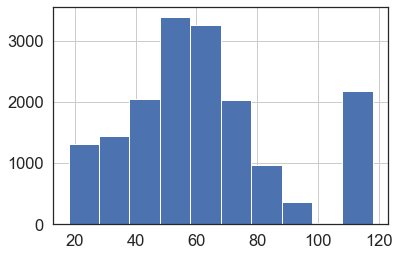

In [334]:
# Let's check the distribution of age, coz I just saw 118!
profile.age.hist()

Observation: The age value 118 doesn't make sense as it is out of the normal distribution.

Inference: It's an outlier that needs to be removed.

In [335]:
# Checking the corresponding age and gender values for age=118
profile[profile['age'] == 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

Observation: The rows containing age as 118 also contain gender and income as Null

Inference: We can safely drop these rows during preprocessing as they do not contain information.

In [336]:
# become_member_on is an interesting column to be explored
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

Observation: These are dates in format YYYYMMDD

Inference: Useful in checking how long the user is a member.

In [337]:
# Checking the total number of unique customers
profile.id.nunique()

17000

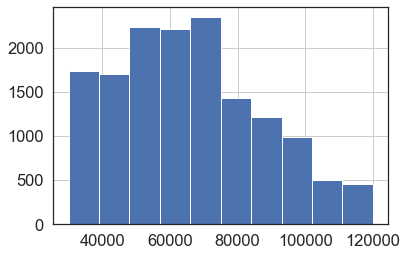

In [338]:
# Checking the income scales
profile.income.hist()

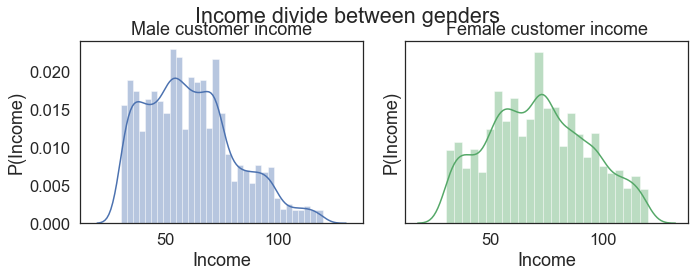

In [339]:
# Income probabilities of genders
male_customers = profile[profile['gender'] == 'M']
female_customers = profile[profile['gender'] == 'F']

palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

fig.suptitle("Income divide between genders")

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=palette[0])
plt.xlabel('Income')
plt.ylabel('P(Income)')
plt.title('Male customer income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=palette[2])
plt.xlabel('Income')
plt.ylabel('P(Income)')
plt.title('Female customer income')
plt.tight_layout()

In [340]:
# Converting became_member_on to datetime
profile.became_member_on =  pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile.became_member_on.head()

0   2017-02-12
1   2017-07-15
2   2018-07-12
3   2017-05-09
4   2017-08-04
Name: became_member_on, dtype: datetime64[ns]

In [341]:
# Extracting year out of the became_member_on column
profile['became_member_on_year'] = profile.became_member_on.apply(lambda x: x.year)
profile['became_member_on_year'].head()

0    2017
1    2017
2    2018
3    2017
4    2017
Name: became_member_on_year, dtype: int64

Text(0, 0.5, 'Count')

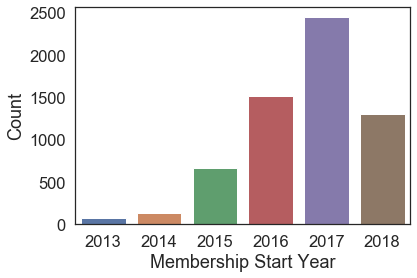

In [342]:
female_membership_data = profile[profile['gender'] == 'F'].groupby('became_member_on_year')['id'].count().to_frame()
female_membership_data['year'] = female_membership_data.index
sns.barplot(x='year', y='id', data =female_membership_data)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

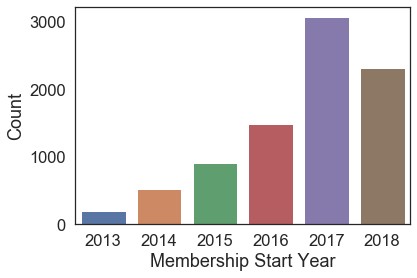

In [343]:
male_membership_data = profile[profile['gender'] == 'M'].groupby('became_member_on_year')['id'].count().to_frame()
male_membership_data['year'] = male_membership_data.index
sns.barplot(x='year', y='id', data = male_membership_data)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

### Exploring transcript

In [344]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Observation: value is a nested json

Inference: need to extract nested json to columns

In [345]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

Observation: No Null values

Inference: Yay! No need to impute or drop rows

In [346]:
transcript.groupby('event')['person'].count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

Observation: The transaction are the highest while offer completed is the lowest.

Inference: The aim is to increase offer completed

In [347]:
# number of unique people in the transcript
transcript['person'].nunique()

17000

In [348]:
transcript.value.tail(10)

306524                                    {'amount': 25.14}
306525                                    {'amount': 43.58}
306526                                    {'amount': 22.64}
306527    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528                                      {'amount': 2.2}
306529                       {'amount': 1.5899999999999999}
306530                                     {'amount': 9.53}
306531                                     {'amount': 3.61}
306532                       {'amount': 3.5300000000000002}
306533                                     {'amount': 4.05}
Name: value, dtype: object

Observation: value column containg more than just offer id

In [349]:
# remove customer ids that are not in profile dataset
selected_data = transcript['person'].isin(profile['id'])
transcript = transcript[selected_data]

# extracting columns from value column
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


Observation: offer id and offer_id are duplicate columns

Inference: merge them into one and remove duplicates

In [350]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [351]:
transcript.head()

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


### Further exploration into transaction and portfolio

In [352]:
#renaming column
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
trans_port = transcript.merge(portfolio,how='left',on='offer_id')

In [353]:
trans_port.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

Observation: Transaction doesn't have an offer_id. 

Observation: Informational doesn't have offer completed

Observation: discount has maximum offer completed while bogo has maximum offer viewed

Inference:

An effective sequence for bogo conversion would be:

offer received => offer viewed => transaction => offer completed

An effective sequence for information offer would be:

offer received => offer viewed => transaction

In [354]:
#Get all unique channels in portfolio
channels = np.unique([channel for chans in portfolio['channels'].items() for channel in chans[1]])
print("Unique channels: ", channels)

#To keep the original dataset, we copy the df
portfolio_clean = portfolio.copy(deep=True) 
for channel in channels:
    portfolio_clean["channel_" + channel] = portfolio['channels'].apply(lambda l: 1 if channel in l else 0)

portfolio_clean.drop(columns='channels', inplace=True)
portfolio_clean.head()

Unique channels:  ['email' 'mobile' 'social' 'web']


,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [355]:
# Finding max duration for each offer_type
portfolio_clean.groupby('offer_type')['duration'].max()

offer_type
bogo              7
discount         10
informational     4
Name: duration, dtype: int64

In [356]:
# Finding mix duration for each offer_type
portfolio_clean.groupby('offer_type')['duration'].min()

offer_type
bogo             5
discount         7
informational    3
Name: duration, dtype: int64

Observation: discounts run for max duration while informational are usually given lesser days

## Data Preprocessing

In [357]:
# dropping na as previously observed the nas are present on gender and income columns
profile_clean = profile.dropna()

# removing outlier data
profile_clean = profile_clean[profile_clean['age']<100]

# renaming columns to use merge function later
profile_clean.rename(columns={"id": "user_id"}, inplace=True)

profile_clean.head()

,gender,age,user_id,became_member_on,income,became_member_on_year
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017


In [414]:
# take only offer completed events
completed_transactions = transcript[transcript['event'] == 'offer completed'][['event', 'person', 'time', 'reward', 'offer_id']]

# renaming column to apply merge later
completed_transactions.rename(columns={"person":"user_id"}, inplace=True)

# taking only those transactions for which we have user data
completed_transactions = completed_transactions[completed_transactions['user_id'].isin(profile_clean['user_id'])]

completed_transactions.head()

,event,user_id,time,reward,offer_id
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2.0,2906b810c7d4411798c6938adc9daaa5
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,2.0,fafdcd668e3743c1bb461111dcafc2a4
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,10.0,ae264e3637204a6fb9bb56bc8210ddfd
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,10.0,4d5c57ea9a6940dd891ad53e9dbe8da0


Action explaination: Here the only columns required for my further prediction are event, user_id, time and reward

In [415]:
# merging profile and transactions data
data = pd.DataFrame.merge(profile_clean, completed_transactions,on='user_id')

data.head()

,gender,age,user_id,became_member_on,income,became_member_on_year,event,time,reward,offer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,528,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,132,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,510,10.0,ae264e3637204a6fb9bb56bc8210ddfd
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,510,5.0,f19421c1d4aa40978ebb69ca19b0e20d
4,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,offer completed,522,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [416]:
# merging profile, transactions and portfolio data
data = pd.DataFrame.merge(data, portfolio_clean, on="offer_id")

data.head()

,gender,age,user_id,became_member_on,income,became_member_on_year,event,time,reward_x,offer_id,reward_y,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,528,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,132,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,offer completed,522,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,offer completed,498,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
4,M,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,2017,offer completed,516,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1


Observation: reward columns are duplicate

Inference: need to drop one and rename the other to reward

In [417]:
data.drop('reward_y', axis=1, inplace=True)
data.rename(columns={'reward_x': 'reward'}, inplace=True)
data.head()

,gender,age,user_id,became_member_on,income,became_member_on_year,event,time,reward,offer_id,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,528,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,132,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,offer completed,522,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,offer completed,498,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1
4,M,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,2017,offer completed,516,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1


Observation: time is a useful metric but I'm not using it for the predictions I'm making

Inference: drop time column

In [418]:
data.drop('time', axis=1, inplace=True)
data.head()

,gender,age,user_id,became_member_on,income,became_member_on_year,event,reward,offer_id,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1
4,M,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1


In [419]:
# getting dummies for gender
data = pd.concat([data, pd.get_dummies(data.gender, prefix="gender")], axis=1)
data.head()

,gender,age,user_id,became_member_on,income,became_member_on_year,event,reward,offer_id,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,gender_F,gender_M,gender_O
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1,1,0,0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1,1,0,0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1,0,1,0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1,0,1,0
4,M,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,1,1,0,1,0,1,0


In [420]:
# getting dummies for offer_type
data = pd.concat([data, pd.get_dummies(data.offer_type, prefix="offer")], axis=1)
data.head()

,gender,age,user_id,became_member_on,income,became_member_on_year,event,reward,offer_id,difficulty,...,offer_type,channel_email,channel_mobile,channel_social,channel_web,gender_F,gender_M,gender_O,offer_bogo,offer_discount
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,bogo,1,1,0,1,1,0,0,1,0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,bogo,1,1,0,1,1,0,0,1,0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,bogo,1,1,0,1,0,1,0,1,0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,bogo,1,1,0,1,0,1,0,1,0
4,M,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,bogo,1,1,0,1,0,1,0,1,0


In [421]:
# Number of days the person is a member since
data['membership_days'] = data['became_member_on'].apply(lambda x: (datetime.now() - x).days)

In [422]:
# Saving into pickle file
# open the file
pickle_out = open('filtered_data.pkl', "wb")
    
# write model to it
pickle.dump(data, pickle_out)

# close pickle file
pickle_out.close()
data.head()

,gender,age,user_id,became_member_on,income,became_member_on_year,event,reward,offer_id,difficulty,...,channel_email,channel_mobile,channel_social,channel_web,gender_F,gender_M,gender_O,offer_bogo,offer_discount,membership_days
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,1,1,0,1,1,0,0,1,0,968
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,1,1,0,1,1,0,0,1,0,1035
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,1,1,0,1,0,1,0,1,0,683
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,1,1,0,1,0,1,0,1,0,759
4,M,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,2017,offer completed,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,...,1,1,0,1,0,1,0,1,0,799


### The prediction plan

In this notebook, I'm aiming four different predictions, which together will fuel predict the type of recommendation that needs to be provided for the particular user.

1. The first prediction would including predicting the channels to target
2. The second prediction would be the difficulty of conversion
3. The third prediction would be the duration to run the offer for
4. The fourth prediction would be to have a BOGO offer or a discount offer for the customer


The input variables for all these predictions would be membership_days, gender, income and age

These 4 predictions together give a recommendation strategy for a user.

#### required columns: age, income, membership_days, gender_M, gender_F, gender_O, channel_email, channel_mobile, channel_social, channel_web, difficulty, duration, offer_bogo, offer_discount

In [402]:
data = data[['age', 'income', 'membership_days', 'gender_M', 'gender_F', 'gender_O', 'channel_email', 'channel_mobile', 'channel_social', 'channel_web', 'difficulty', 'duration', 'offer_bogo', 'offer_discount']]

data.head()

,age,income,membership_days,gender_M,gender_F,gender_O,channel_email,channel_mobile,channel_social,channel_web,difficulty,duration,offer_bogo,offer_discount
0,55,112000.0,968,0,1,0,1,1,0,1,5,7,1,0
1,75,100000.0,1035,0,1,0,1,1,0,1,5,7,1,0
2,68,70000.0,683,1,0,0,1,1,0,1,5,7,1,0
3,65,53000.0,759,1,0,0,1,1,0,1,5,7,1,0
4,57,42000.0,799,1,0,0,1,1,0,1,5,7,1,0


### Model 1: predicting channels to target

In [368]:
def build_model():
    """
        Function to build the ML model
        Input:
            -
        Ouput:
            - GridSearchCV object
    """
    
    # Forming Pipleine
    pipeline = Pipeline([
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    # Initializing parameters for Grid search
    parameters = {
        'clf__estimator__n_estimators': [10, 50, 100]    
    }
    
    # GridSearch Object with pipeline and parameters
    cv = GridSearchCV(pipeline, param_grid=parameters)
    
    return cv


In [369]:
X = pd.DataFrame.copy(data[['age', 'income', 'membership_days', 'gender_M', 'gender_F', 'gender_O']])
y = pd.DataFrame.copy(data[['channel_email', 'channel_mobile', 'channel_social', 'channel_web']])

In [370]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [371]:
channel_model = build_model()

In [372]:
channel_model.fit(np.array(X_train), np.array(y_train))

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                                               class_weight=None,
                                                                                               criterion='gini',
                                                                                               max_depth=None,
                                                                                               max_features='auto',
                                                                                               max_leaf_nodes=None,
                                                                                               min_impurity_decrease=0.0,
                                                

In [373]:
def evaluate_model(model, X_test, Y_test, category_names):
    """
        Function to evaluate model
        Inputs:
            - model: the trained model
            - X_test: the testing input variable
            - y_test: the testing probable output variable
            - category_names: names of categories on output
    """
    
    # Predict results of X_test
    y_pred = model.predict(X_test)

    # Converting both y_pred and Y_test into DataFrames
    y_pred = pd.DataFrame(y_pred, columns=category_names)
    Y_test = pd.DataFrame(y_pred, columns=category_names)
    
    # Print classification report and accuracy with respect to each column
    for c in category_names:
        print(c, classification_report(Y_test[c].values, y_pred[c].values))
        print("Accuracy of "+str(c)+": "+str(accuracy_score(Y_test[c].values, y_pred[c].values)))

In [374]:
evaluate_model(channel_model, X_test, y_test, ['channel_email', 'channel_mobile', 'channel_social', 'channel_web'])

channel_email               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6480

    accuracy                           1.00      6480
   macro avg       1.00      1.00      1.00      6480
weighted avg       1.00      1.00      1.00      6480

Accuracy of channel_email: 1.0
channel_mobile               precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       1.00      1.00      1.00      6187

    accuracy                           1.00      6480
   macro avg       1.00      1.00      1.00      6480
weighted avg       1.00      1.00      1.00      6480

Accuracy of channel_mobile: 1.0
channel_social               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1809
           1       1.00      1.00      1.00      4671

    accuracy                           1.00      6480
   macro avg       1.00      1.00      1.00      6480
weighted avg       1.

As you can see from the above the accuracy of the system is 100%

In [375]:
def save_model(model, model_filepath):
    """
        Function to save the ML model
    """
    
    # open the file
    pickle_out = open(model_filepath, "wb")
    
    # write model to it
    pickle.dump(model, pickle_out)
    
    # close pickle file
    pickle_out.close()

In [376]:
save_model(channel_model, 'channel_model.pkl')

### Model 2: Predicting the difficulty in conversion of the user

In [377]:
def build_model_without_multiclass():
    """
        Function to build the ML model
        Input:
            -
        Ouput:
            - GridSearchCV object
    """
    
    # Forming Pipleine
    pipeline = Pipeline([
        ('clf', RandomForestClassifier())
    ])
    
    # Initializing parameters for Grid search
    parameters = {
        'clf__n_estimators': [10, 50, 100]    
    }
    
    # GridSearch Object with pipeline and parameters
    cv = GridSearchCV(pipeline, param_grid=parameters)
    
    return cv


In [378]:
difficulty_model = build_model_without_multiclass()

In [379]:
X = pd.DataFrame.copy(data[['age', 'income', 'membership_days', 'gender_M', 'gender_F', 'gender_O']])
y = pd.DataFrame.copy(data['difficulty'])

In [380]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [381]:
difficulty_model.fit(np.array(X_train), np.array(Y_train))

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                 

In [382]:
evaluate_model(difficulty_model, X_test, Y_test, ['difficulty'])

difficulty               precision    recall  f1-score   support

           5       1.00      1.00      1.00      1420
           7       1.00      1.00      1.00       714
          10       1.00      1.00      1.00      3886
          20       1.00      1.00      1.00       460

    accuracy                           1.00      6480
   macro avg       1.00      1.00      1.00      6480
weighted avg       1.00      1.00      1.00      6480

Accuracy of difficulty: 1.0


As you can see from the above, the accuracy on testing is 100%

In [383]:
save_model(difficulty_model, 'difficulty_model.pkl')

### Model 3: Predicting the duration to run the offer for

In [384]:
duration_model = build_model_without_multiclass()

In [385]:
X = pd.DataFrame.copy(data[['age', 'income', 'membership_days', 'gender_M', 'gender_F', 'gender_O']])
y = pd.DataFrame.copy(data['duration'])

In [386]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [387]:
duration_model.fit(np.array(X_train), np.array(Y_train))

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                 

In [388]:
evaluate_model(duration_model, X_test, Y_test, ['duration'])

duration               precision    recall  f1-score   support

           5       1.00      1.00      1.00      1200
           7       1.00      1.00      1.00      3879
          10       1.00      1.00      1.00      1401

    accuracy                           1.00      6480
   macro avg       1.00      1.00      1.00      6480
weighted avg       1.00      1.00      1.00      6480

Accuracy of duration: 1.0


As you can see from the above, the accuracy of the model is 100%

In [389]:
save_model(duration_model, 'duration_model.pkl')

### Model 4: Predicting offer type

In [390]:
offer_model = build_model()

In [391]:
X = pd.DataFrame.copy(data[['age', 'income', 'membership_days', 'gender_M', 'gender_F', 'gender_O']])
y = pd.DataFrame.copy(data[['offer_bogo', 'offer_discount']])

In [392]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [393]:
offer_model.fit(np.array(X_train), np.array(Y_train))

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                                               class_weight=None,
                                                                                               criterion='gini',
                                                                                               max_depth=None,
                                                                                               max_features='auto',
                                                                                               max_leaf_nodes=None,
                                                                                               min_impurity_decrease=0.0,
                                                

In [394]:
evaluate_model(offer_model, X_test, Y_test, ['offer_bogo', 'offer_discount'])

offer_bogo               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3607
           1       1.00      1.00      1.00      2873

    accuracy                           1.00      6480
   macro avg       1.00      1.00      1.00      6480
weighted avg       1.00      1.00      1.00      6480

Accuracy of offer_bogo: 1.0
offer_discount               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2870
           1       1.00      1.00      1.00      3610

    accuracy                           1.00      6480
   macro avg       1.00      1.00      1.00      6480
weighted avg       1.00      1.00      1.00      6480

Accuracy of offer_discount: 1.0


In [395]:
save_model(offer_model, 'offer_model.pkl')

As seen above, this model also has an accuracy of 100%

In [396]:
def get_results(age, income, membership_days, gender_M, gender_F, gender_O):
    """
        Function to call all three models, and output the results
        Input:
            - age: Age of the customer
            - income: Income of the customer
            - membership_days: Number of days the customer is a member of Starbucks (today's date - membership date)
            - gender_M: 1 if customer is male
            - gender_F: 1 is customer is female
            - gender_O: 1 is customer is of other gender
        Ouput:
            - dictionary containing channel, difficulty and duration
    """
    inp = [[age, income, membership_days, gender_M, gender_F, gender_O]]
    channel = channel_model.predict(inp)[0]
    channels = []
    if channel[0] == 1:
        channels.append("email")
    if channel[1] == 1:
        channels.append("mobile")
    if channel[2] == 1:
        channels.append("social")
    if channel[3] == 1:
        channels.append("web")
    difficulty = difficulty_model.predict(inp)[0]
    duration = duration_model.predict(inp)[0]
    offers = offer_model.predict(inp)[0]
    offer = ""
    if offers[0] == 1:
        offer = "bogo"
    elif offers[1] == 1:
        offer = "discount"
    res = {
        "channels": channels,
        "difficulty": difficulty,
        "duration": duration,
        "offer": offer
    }
    return res

In [397]:
# Testing a random sample data
get_results(55, 112000.0, 1005, 0, 1, 0)

{'channels': ['email', 'mobile', 'social', 'web'],
 'difficulty': 5,
 'duration': 7,
 'offer': 'bogo'}

## Conclusion

For explanation on precision and recall of model, please refer my article here:
https://towardsdatascience.com/precision-and-recall-a-simplified-view-bc25978d81e6

### The above models together predict the type of recommendation to be presented to the user that the user will take it.

Yes, the models are useless if we don't have user age, gender and income information. But, these models are assuming that we have age, gender and income information of the user.

### accuracy concerns
The model gave a 100% accuracy on testing dataset. This means that it has not overfit the training dataset (or) the there is not enough variety in the training and testing dataset.

### Testing the recommendation mechanism
This can be done using experimental design. A/B testing would be the best possible way to tackle this scenario. But, as the channels of recommendation spread across web, mobile, social media and email. We need to record the data with respect to each channel and use proper statistic methods to evaluate the models predictions. Also, the data needs to be collected properly and for long enough to avoid type I and type II errors.

### Future improvements
Using deep learning and neural networks can better the learning for a much larger dataset (as that of the real starbucks dataset) resulting is much better decisions and accuracy.